# This notebook will perform a Time Series Analysis of Eve pvp data using ARIMA modeling.

This analysis will attempt to draw meaningful conclusions from the Beeitnam war PVP data provided on the r/eve subreddit by u/Normann_Tivianne. It's clear from the numbers posted that since the siege of 3-D began, Imperium participation is rising, while PAPI participation is falling. But what (if anything) does the past and current data predict about future participation? Using time series forecasting techniques, we can answer that question.

## Importing and prepping the data

In [232]:
import warnings

warnings.filterwarnings("ignore")

In [233]:
import os
import pandas as pd

pwd = os.getcwd()

path = pwd + "/raw_data/"

evedata_df = pd.read_csv(path + 'evedata.csv', index_col='date', parse_dates= True)

evedata_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 85 entries, 2020-01-06 to 2021-08-16
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   northern_conflict  85 non-null     int64  
 1   war_begins         85 non-null     int64  
 2   war_begins_panfam  85 non-null     int64  
 3   fwst               85 non-null     int64  
 4   m2                 85 non-null     int64  
 5   1dq_siege          85 non-null     int64  
 6   gsf                74 non-null     float64
 7   init               74 non-null     float64
 8   ph                 74 non-null     float64
 9   test               74 non-null     float64
 10  brave              74 non-null     float64
 11  nc                 74 non-null     float64
 12  eve chars          74 non-null     float64
 13  imperium           74 non-null     float64
 14  log_imperium       74 non-null     float64
 15  legacy             74 non-null     float64
 16  log_lega

In [234]:
evedata_df

,northern_conflict,war_begins,war_begins_panfam,fwst,m2,1dq_siege,gsf,init,ph,test,...,other papi,log_otherpapi,fraternity,fire,slicy,eve kms,pl,wh space,imperium wo caps,papi wo caps
date,,,,,,,,,,,,,,,,,,,,,
2020-01-06,0,0,0,0,0,0,2268.0,703.0,1505.0,1284.0,...,2646.0,3.422590,1628.0,801.0,217.0,100760.0,279.0,4501.0,3874.0,7374.0
2020-01-13,0,0,0,0,0,0,2242.0,714.0,1631.0,1138.0,...,2311.0,3.363800,1333.0,772.0,206.0,101662.0,201.0,4881.0,3886.0,6958.0
2020-01-20,0,0,0,0,0,0,2223.0,707.0,1715.0,1263.0,...,2547.0,3.406029,1568.0,802.0,177.0,102620.0,208.0,4910.0,3848.0,7493.0
2020-01-27,0,0,0,0,0,0,1583.0,536.0,1445.0,852.0,...,2517.0,3.400883,1664.0,715.0,138.0,89349.0,178.0,4156.0,3078.0,6639.0
2020-02-03,0,0,0,0,0,0,2317.0,646.0,1799.0,1050.0,...,3066.0,3.486572,2090.0,807.0,169.0,101864.0,243.0,4466.0,3935.0,7842.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-19,0,0,0,0,0,1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-07-26,0,0,0,0,0,1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-08-02,0,0,0,0,0,1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [235]:
imp_df = evedata_df["imperium"].iloc[0:74]
legacy_df = evedata_df["legacy"].iloc[0:74]
panfam_df = evedata_df["panfam"].iloc[0:74]
papi_df = evedata_df["papi_total"].iloc[0:74]
impsub_df = evedata_df["imperium wo caps"].iloc[0:74]
papisub_df = evedata_df["papi wo caps"].iloc[0:74]


In [236]:
imp_df.index

DatetimeIndex(['2020-01-06', '2020-01-13', '2020-01-20', '2020-01-27',
               '2020-02-03', '2020-02-10', '2020-02-17', '2020-02-24',
               '2020-03-02', '2020-03-09', '2020-03-16', '2020-03-23',
               '2020-03-30', '2020-04-06', '2020-04-13', '2020-04-20',
               '2020-04-27', '2020-05-04', '2020-05-11', '2020-05-18',
               '2020-05-25', '2020-06-01', '2020-06-08', '2020-06-15',
               '2020-06-22', '2020-06-29', '2020-07-06', '2020-07-13',
               '2020-07-20', '2020-07-27', '2020-08-03', '2020-08-10',
               '2020-08-17', '2020-08-24', '2020-08-31', '2020-09-07',
               '2020-09-14', '2020-09-21', '2020-09-28', '2020-10-05',
               '2020-10-12', '2020-10-19', '2020-10-26', '2020-11-02',
               '2020-11-09', '2020-11-16', '2020-11-23', '2020-11-30',
               '2020-12-07', '2020-12-14', '2020-12-21', '2020-12-28',
               '2021-01-04', '2021-01-11', '2021-01-18', '2021-01-25',
      

In [237]:
imp_df

date
2020-01-06    4180.0
2020-01-13    4137.0
2020-01-20    4134.0
2020-01-27    3284.0
2020-02-03    4160.0
               ...  
2021-05-03    4440.0
2021-05-10    4405.0
2021-05-17    4569.0
2021-05-24    4148.0
2021-05-31    4469.0
Name: imperium, Length: 74, dtype: float64

## Visualizing the data

In [238]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

<AxesSubplot:title={'center':'Legacy PVP Participaton'}, xlabel='date'>

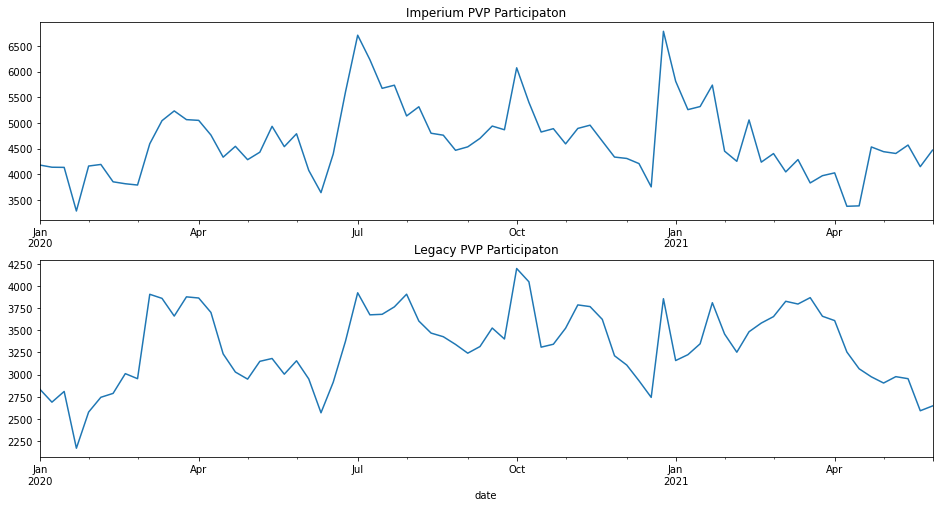

In [300]:
fig, axes = plt.subplots(2)

imp_df.plot(y = 'imperium', title = "Imperium PVP Participaton", xlabel = "", ax=axes[0])
legacy_df.plot(y = 'legacy', title = "Legacy PVP Participaton", ax=axes[1])



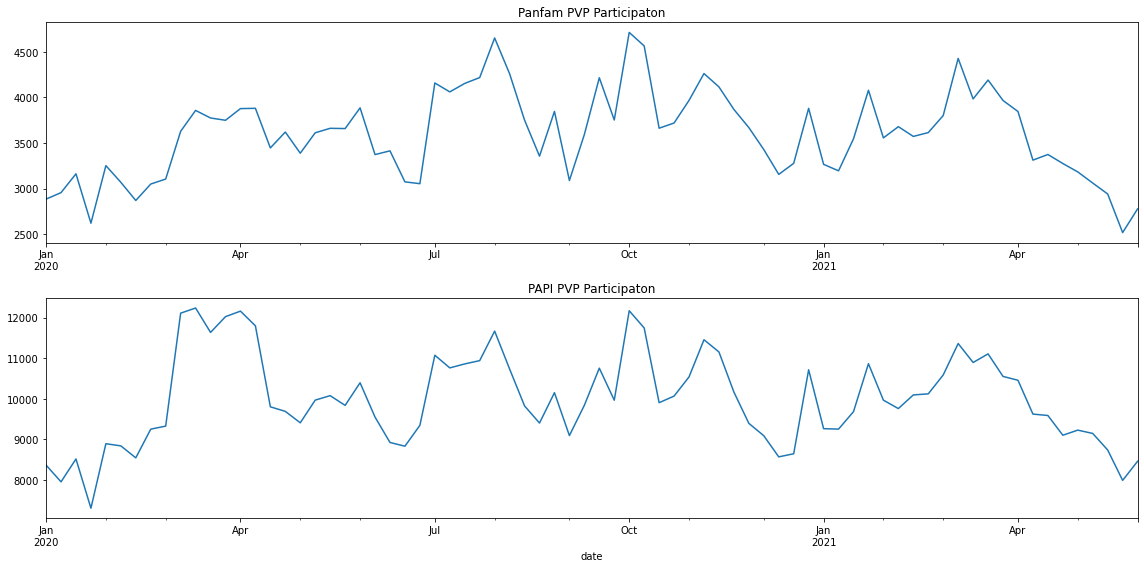

In [301]:
fig, axes = plt.subplots(2)

panfam_df.plot(y = 'panfam', title = "Panfam PVP Participaton", xlabel = "", ax=axes[0])
papi_df.plot(y = 'papi_total', title = "PAPI PVP Participaton", ax=axes[1])

plt.tight_layout()

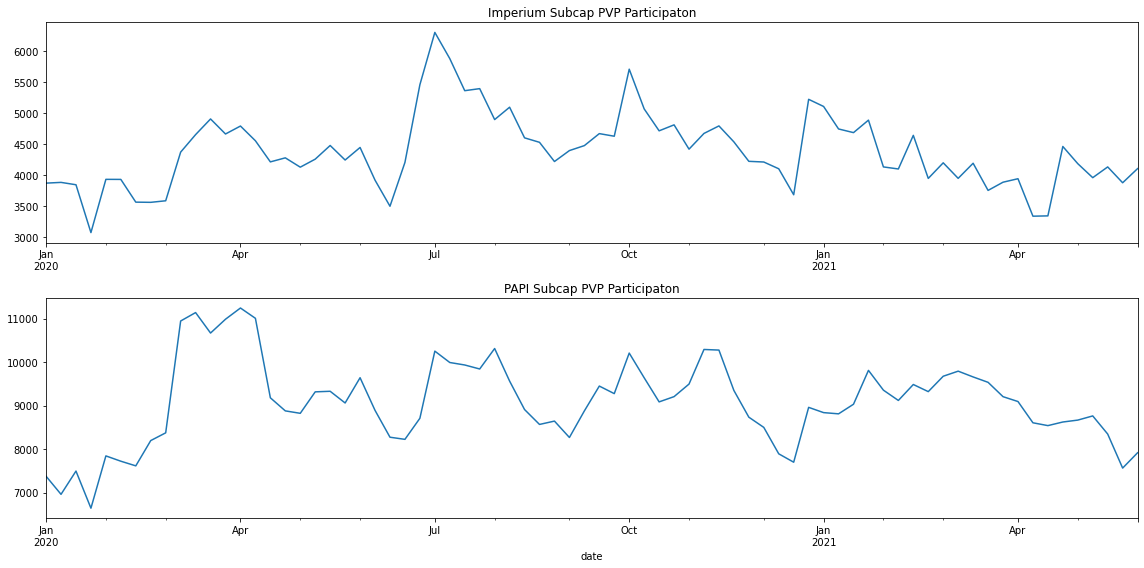

In [302]:
fig, axes = plt.subplots(2)

impsub_df.plot(y = 'imperium wo caps', title = "Imperium Subcap PVP Participaton", xlabel = "", ax=axes[0])
papisub_df.plot(y = 'papi wo caps', title = "PAPI Subcap PVP Participaton", ax=axes[1])

plt.tight_layout()

## Augmented Dickey-Fuller test for stationarity:

In [242]:
for column in evedata_df[['imperium', 'legacy', 'panfam', 'papi_total', 'imperium wo caps', 'papi wo caps']].iloc[0:74]:
    result = adfuller(evedata_df[column].iloc[0:74])
    print("\n",column, 'ADF Results:')
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))


 imperium ADF Results:
ADF Statistic: -4.096921694171093
p-value: 0.000979934217847856
Critical Values:
	1%: -3.5232835753964475
	5%: -2.902030597326081
	10%: -2.5883710883843123

 legacy ADF Results:
ADF Statistic: -3.2935204091578894
p-value: 0.015170608545654071
Critical Values:
	1%: -3.5232835753964475
	5%: -2.902030597326081
	10%: -2.5883710883843123

 panfam ADF Results:
ADF Statistic: -3.6836395092265293
p-value: 0.004349253688484767
Critical Values:
	1%: -3.5232835753964475
	5%: -2.902030597326081
	10%: -2.5883710883843123

 papi_total ADF Results:
ADF Statistic: -3.500060313614315
p-value: 0.007985545215232167
Critical Values:
	1%: -3.5232835753964475
	5%: -2.902030597326081
	10%: -2.5883710883843123

 imperium wo caps ADF Results:
ADF Statistic: -3.5737068856509846
p-value: 0.006284054656371292
Critical Values:
	1%: -3.5232835753964475
	5%: -2.902030597326081
	10%: -2.5883710883843123

 papi wo caps ADF Results:
ADF Statistic: -3.56246388251624
p-value: 0.00652054224382692
C

### All time series are stationary at a 95% confidence level.

## Selecting the appropriate ARIMA models:

Because we are working with relatively small datasets (<100 points) and there is an ongoing exogenous factor at the end of the series, we will not utilize a test/training split.

In [243]:
from pmdarima.arima import auto_arima

In [244]:
imp_arima = auto_arima(imp_df, trace = True, error_action = 'warn', suppress_warnings = False,)
imp_arima.fit(imp_df)
print(imp_arima.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=1156.740, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1184.588, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1150.886, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1159.528, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1463.613, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=1152.896, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1152.885, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1154.885, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.01 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.274 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   74
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -572.443
Date:                Sun, 10 Oct 2021   AIC           

In [245]:
legacy_arima = auto_arima(legacy_df, trace = True, error_action = 'warn', suppress_warnings = False,)
legacy_arima.fit(legacy_df)
print(legacy_arima.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=1064.744, Time=0.17 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1110.461, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1058.916, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1075.957, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1413.196, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=1060.945, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1061.173, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1062.895, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.01 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.377 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   74
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -526.458
Date:                Sun, 10 Oct 2021   AIC           

In [246]:
panfam_arima = auto_arima(panfam_df, trace = True, error_action = 'warn', suppress_warnings = False,)
panfam_arima.fit(panfam_df)
print(panfam_arima.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=1089.330, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1125.866, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1084.166, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1098.005, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1425.233, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=1085.723, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1085.841, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1087.671, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.01 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.266 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   74
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -539.083
Date:                Sun, 10 Oct 2021   AIC           

In [247]:
papi_arima = auto_arima(papi_df, trace = True, error_action = 'warn', suppress_warnings = False,)
papi_arima.fit(papi_df)
print(papi_arima.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=1209.819, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1253.067, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1204.064, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1218.763, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1575.930, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=1206.123, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1206.178, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1208.121, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.01 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.297 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   74
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -599.032
Date:                Sun, 10 Oct 2021   AIC           

In [248]:
impsub_arima = auto_arima(impsub_df, trace = True, error_action = 'warn', suppress_warnings = False,)
impsub_arima.fit(impsub_df)
print(papi_arima.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=1117.457, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1159.228, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1111.790, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1125.209, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1454.538, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=1113.671, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1113.687, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1115.699, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.01 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.224 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   74
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -599.032
Date:                Sun, 10 Oct 2021   AIC           

In [249]:
papisub_arima = auto_arima(papisub_df, trace = True, error_action = 'warn', suppress_warnings = False,)
papisub_arima.fit(papisub_df)
print(papisub_arima.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=1166.369, Time=0.17 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1232.109, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1162.009, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1181.512, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1561.595, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=1162.388, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1162.699, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1163.146, Time=0.12 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.01 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.457 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   74
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -578.004
Date:                Sun, 10 Oct 2021   AIC           

### All individual data sets are of the order AR(1,0,0) with intercept.

## Applying the Models:

We will use the following exogenous variables (or Time Series Interruptions) with our data sets: Northern Conflict, War Begins, FWST, M2, 1DQ Siege (begins), and 1DQ Seige (ongoing). Each of these factors affected the groups in slightly different ways, which our modeling takes into account. Since we know the interruptions affected player participation, we should not remove them from the model based on significance alone. We should instead use the relative strength/weakness of these values to draw further conclusions. 

We will also perform a residual analysis on the ARIMA modeled values.

In [250]:
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

In [251]:
exogx = evedata_df[['northern_conflict', "war_begins", "fwst", "m2", "1dq_siege"]].iloc[0:74]
exogx3 = evedata_df[['northern_conflict', "war_begins_panfam", "fwst", "m2", "1dq_siege"]].iloc[0:74]

In [252]:
imp_fit=ARIMA(imp_df, exog = exogx, order=(1,0,0))
imp_fit=imp_fit.fit()
imp_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               imperium   No. Observations:                   74
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -548.394
Date:                Sun, 10 Oct 2021   AIC                           1112.789
Time:                        13:37:49   BIC                           1131.221
Sample:                    01-06-2020   HQIC                          1120.142
                         - 05-31-2021                                         
Covariance Type:                  opg                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              4371.7223    153.083     28.558      0.000    4071.686    4671.759
northern_conflict   552.9825    620.096      0.892      0.373    -662.383    1768.348
war_begins         1052.6690    252.759      4.165      0.000     557.271    1548.067
fwst                975.5213    319.817      3.050      0.002     348.691    1602.351
m2                 2003.9568    175.730     11.404      0.000    1659.532    2348.382
1dq_siege           478.7347    417.961      1.145      0.252    -340.454    1297.924
ar.L1                 0.6778      0.097      6.984      0.000       0.488       0.868
sigma2             1.588e+05   2.55e+04      6.217      0.000    1.09e+05    2.09e+05
===================================================================================
Ljung-Box (L1) (Q):                   1.30   Jarque-Bera (JB):                 0.48
Prob(Q):                              0.25   Prob(JB):                         0.79
Heteroskedasticity (H):               1.60   Skew:                             0.16
Prob(H) (two-sided):                  0.25   Kurtosis:                         3.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [253]:
legacy_fit=ARIMA(legacy_df, exog = exogx, order=(1,0,0))
legacy_fit=legacy_fit.fit()
legacy_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 legacy   No. Observations:                   74
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -508.336
Date:                Sun, 10 Oct 2021   AIC                           1032.673
Time:                        13:37:49   BIC                           1051.105
Sample:                    01-06-2020   HQIC                          1040.026
                         - 05-31-2021                                         
Covariance Type:                  opg                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              3210.3098    125.100     25.662      0.000    2965.119    3455.500
northern_conflict   567.3983    115.340      4.919      0.000     341.336     793.461
war_begins          245.9752    179.048      1.374      0.170    -104.952     596.903
fwst                775.8515    691.787      1.122      0.262    -580.027    2131.730
m2                  682.5072    125.883      5.422      0.000     435.781     929.234
1dq_siege          -253.6599    350.662     -0.723      0.469    -940.944     433.624
ar.L1                 0.7790      0.089      8.722      0.000       0.604       0.954
sigma2             5.355e+04   7859.527      6.813      0.000    3.81e+04     6.9e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 7.34
Prob(Q):                              0.87   Prob(JB):                         0.03
Heteroskedasticity (H):               0.91   Skew:                            -0.58
Prob(H) (two-sided):                  0.82   Kurtosis:                         4.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [254]:
panfam_fit=ARIMA(panfam_df, exog = exogx3, order=(1,0,0))
panfam_fit=panfam_fit.fit()
panfam_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 panfam   No. Observations:                   74
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -526.785
Date:                Sun, 10 Oct 2021   AIC                           1069.570
Time:                        13:37:49   BIC                           1088.003
Sample:                    01-06-2020   HQIC                          1076.923
                         - 05-31-2021                                         
Covariance Type:                  opg                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              3516.0987    112.141     31.354      0.000    3296.306    3735.891
northern_conflict   254.2358    350.476      0.725      0.468    -432.685     941.157
war_begins_panfam   528.3235    149.248      3.540      0.000     235.803     820.844
fwst                955.3835    889.579      1.074      0.283    -788.160    2698.927
m2                  455.1407    366.636      1.241      0.214    -263.453    1173.734
1dq_siege          -420.8383    284.612     -1.479      0.139    -978.667     136.990
ar.L1                 0.6854      0.100      6.822      0.000       0.488       0.882
sigma2             8.863e+04   1.55e+04      5.714      0.000    5.82e+04    1.19e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 0.08
Prob(Q):                              0.87   Prob(JB):                         0.96
Heteroskedasticity (H):               1.18   Skew:                             0.08
Prob(H) (two-sided):                  0.68   Kurtosis:                         3.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [255]:
papi_fit=ARIMA(papi_df, exog = exogx3, order=(1,0,0))
papi_fit=papi_fit.fit()
papi_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             papi_total   No. Observations:                   74
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -582.478
Date:                Sun, 10 Oct 2021   AIC                           1180.956
Time:                        13:37:49   BIC                           1199.389
Sample:                    01-06-2020   HQIC                          1188.309
                         - 05-31-2021                                         
Covariance Type:                  opg                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              9580.2340    262.246     36.531      0.000    9066.241    1.01e+04
northern_conflict  1742.8095    278.128      6.266      0.000    1197.688    2287.931
war_begins_panfam   891.9184    367.068      2.430      0.015     172.479    1611.358
fwst               2054.0742   1236.916      1.661      0.097    -370.237    4478.385
m2                 1133.4110    495.187      2.289      0.022     162.862    2103.960
1dq_siege          -874.6994    871.214     -1.004      0.315   -2582.248     832.849
ar.L1                 0.7142      0.077      9.318      0.000       0.564       0.864
sigma2             3.983e+05   7.14e+04      5.582      0.000    2.58e+05    5.38e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 0.21
Prob(Q):                              0.89   Prob(JB):                         0.90
Heteroskedasticity (H):               0.59   Skew:                            -0.13
Prob(H) (two-sided):                  0.19   Kurtosis:                         2.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [256]:
impsub_fit=ARIMA(impsub_df, exog = exogx, order=(1,0,0))
impsub_fit=impsub_fit.fit()
impsub_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:       imperium wo caps   No. Observations:                   74
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -533.850
Date:                Sun, 10 Oct 2021   AIC                           1083.699
Time:                        13:37:49   BIC                           1102.132
Sample:                    01-06-2020   HQIC                          1091.052
                         - 05-31-2021                                         
Covariance Type:                  opg                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              4140.9401    159.202     26.011      0.000    3828.910    4452.970
northern_conflict   507.9919    373.516      1.360      0.174    -224.086    1240.070
war_begins          920.6601    176.231      5.224      0.000     575.253    1266.067
fwst                737.4214    188.147      3.919      0.000     368.661    1106.182
m2                 1123.7217    280.770      4.002      0.000     573.423    1674.021
1dq_siege           481.2323    250.754      1.919      0.055     -10.236     972.701
ar.L1                 0.7524      0.083      9.107      0.000       0.590       0.914
sigma2             1.069e+05   1.81e+04      5.889      0.000    7.13e+04    1.42e+05
===================================================================================
Ljung-Box (L1) (Q):                   1.79   Jarque-Bera (JB):                 0.09
Prob(Q):                              0.18   Prob(JB):                         0.96
Heteroskedasticity (H):               0.98   Skew:                             0.08
Prob(H) (two-sided):                  0.97   Kurtosis:                         3.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [257]:
papisub_fit=ARIMA(papisub_df, exog = exogx3, order=(1,0,0))
papisub_fit=papisub_fit.fit()
papisub_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           papi wo caps   No. Observations:                   74
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -565.781
Date:                Sun, 10 Oct 2021   AIC                           1147.562
Time:                        13:37:50   BIC                           1165.994
Sample:                    01-06-2020   HQIC                          1154.915
                         - 05-31-2021                                         
Covariance Type:                  opg                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              8670.4153    262.851     32.986      0.000    8155.237    9185.594
northern_conflict  1500.5483    177.580      8.450      0.000    1152.499    1848.598
war_begins_panfam   866.0177    262.372      3.301      0.001     351.778    1380.258
fwst                783.1124    708.167      1.106      0.269    -604.870    2171.095
m2                  770.1185    561.168      1.372      0.170    -329.750    1869.987
1dq_siege          -336.7761    592.525     -0.568      0.570   -1498.103     824.551
ar.L1                 0.7931      0.056     14.140      0.000       0.683       0.903
sigma2             2.527e+05   4.09e+04      6.186      0.000    1.73e+05    3.33e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):                 0.37
Prob(Q):                              0.74   Prob(JB):                         0.83
Heteroskedasticity (H):               0.30   Skew:                            -0.02
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [258]:
imp_model_results_df = pd.DataFrame(imp_fit.params, columns = ["Imperium"])
legacy_model_results_df = pd.DataFrame(legacy_fit.params, columns = ["Legacy"])
panfam_model_results_df = pd.DataFrame(panfam_fit.params, columns = ["Panfam"])
papi_model_results_df = pd.DataFrame(papi_fit.params, columns = ["PAPI"])
impsub_model_results_df = pd.DataFrame(impsub_fit.params, columns = ["Imperium Subcaps"])
papisub_model_results_df = pd.DataFrame(papisub_fit.params, columns = ["PAPI Subcaps"])

In [370]:
imp_p = pd.DataFrame(imp_fit.pvalues.astype(float).round(4), columns = ["P-values"])
legacy_p = pd.DataFrame(legacy_fit.pvalues.astype(float).round(4), columns = ["P-values"])
panfam_p = pd.DataFrame(panfam_fit.pvalues.astype(float).round(4), columns = ["P-values"])
papi_p = pd.DataFrame(papi_fit.pvalues.astype(float).round(4), columns = ["P-values"])
impsub_p= pd.DataFrame(impsub_fit.pvalues.astype(float).round(4), columns = ["P-values"])
papisub_p = pd.DataFrame(papisub_fit.pvalues.astype(float).round(4), columns = ["P-values"])

In [372]:
model_results = pd.concat([imp_model_results_df, imp_p, legacy_model_results_df, legacy_p, panfam_model_results_df, panfam_p, papi_model_results_df, papi_p,
impsub_model_results_df, impsub_p, papisub_model_results_df, papisub_p], axis = 1)
print(model_results)
model_results.to_csv(os.path.join('export_data','eve_arimaresults.csv'))

                        Imperium  P-values        Legacy  P-values  \
const                4371.722350    0.0000   3210.309778    0.0000   
northern_conflict     552.982474    0.3725    567.398335    0.0000   
war_begins           1052.668981    0.0000    245.975165    0.1695   
fwst                  975.521268    0.0023    775.851466    0.2621   
m2                   2003.956832    0.0000    682.507205    0.0000   
1dq_siege             478.734677    0.2520   -253.659930    0.4694   
ar.L1                   0.677751    0.0000      0.778970    0.0000   
sigma2             158772.712407    0.0000  53547.889712    0.0000   
war_begins_panfam            NaN       NaN           NaN       NaN   

                         Panfam  P-values           PAPI  P-values  \
const               3516.098699    0.0000    9580.233986    0.0000   
northern_conflict    254.235783    0.4682    1742.809524    0.0000   
war_begins                  NaN       NaN            NaN       NaN   
fwst               

## AR Coefficient Comparison

Comparing the AR coefficients (momentum impact- the closer this value is to 1, the more important the most recent values are) from each group yields interesting results as well: while pvp participation numbers for everyone are affected by more recent numbers, **Legacy is by far the most impacted individually.** As a whole, PAPI cares a lot more about recent results than the Imperium:

|       Group      | AR Coefficient |
|:----------------:|:--------------:|
| Imperium         | 0.678          |
| Panfam           | 0.685          |
| PAPI             | 0.714          |
| Imperium Subcaps | 0.752          |
| Legacy           | 0.779          |
| PAPI Subcaps     | 0.793          |

Imperium Residuals:


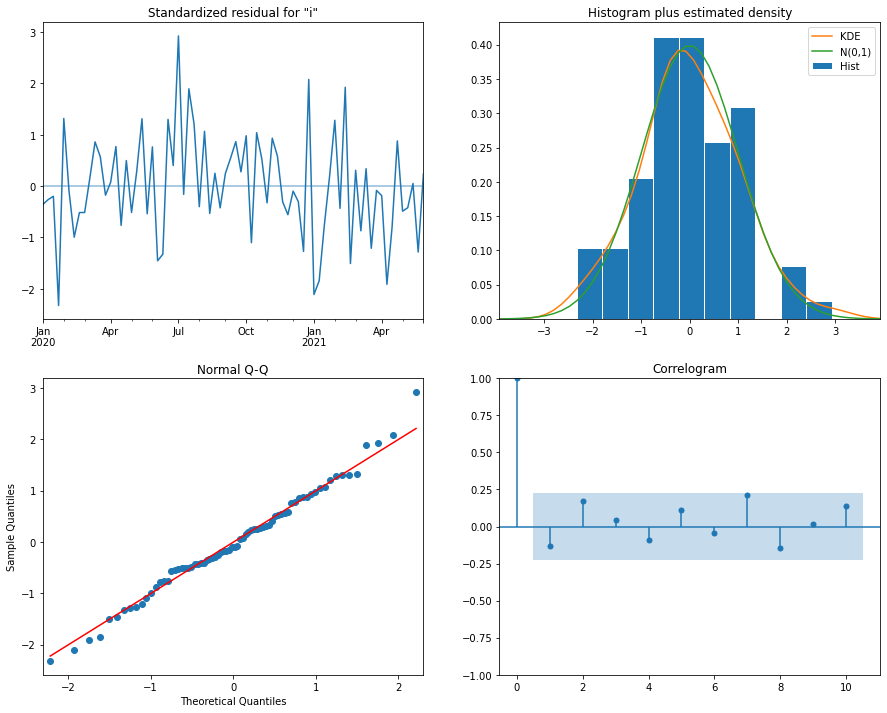


 Legacy Residuals:


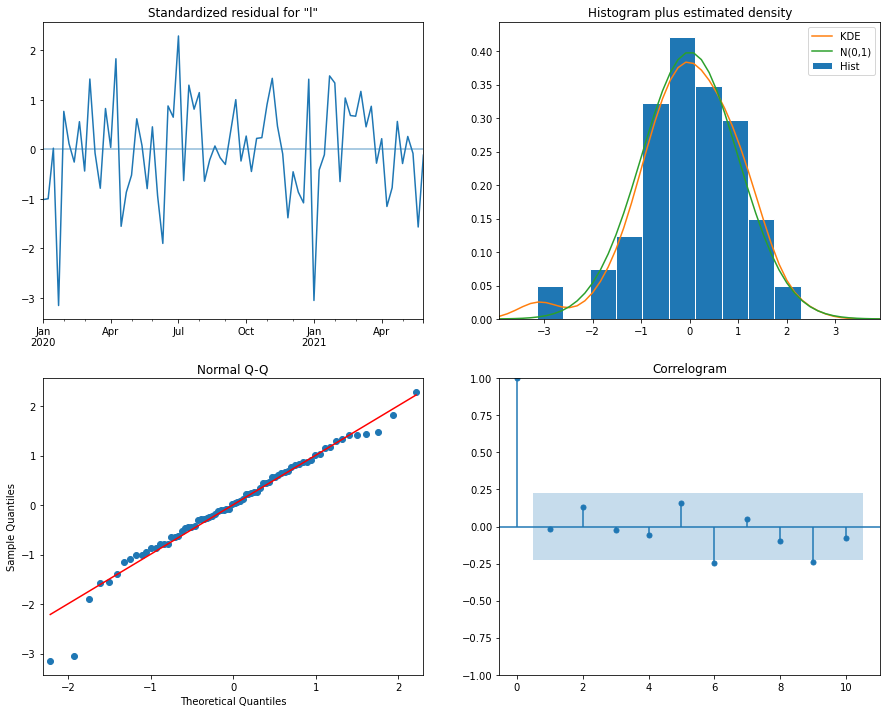


 Panfam Residuals:


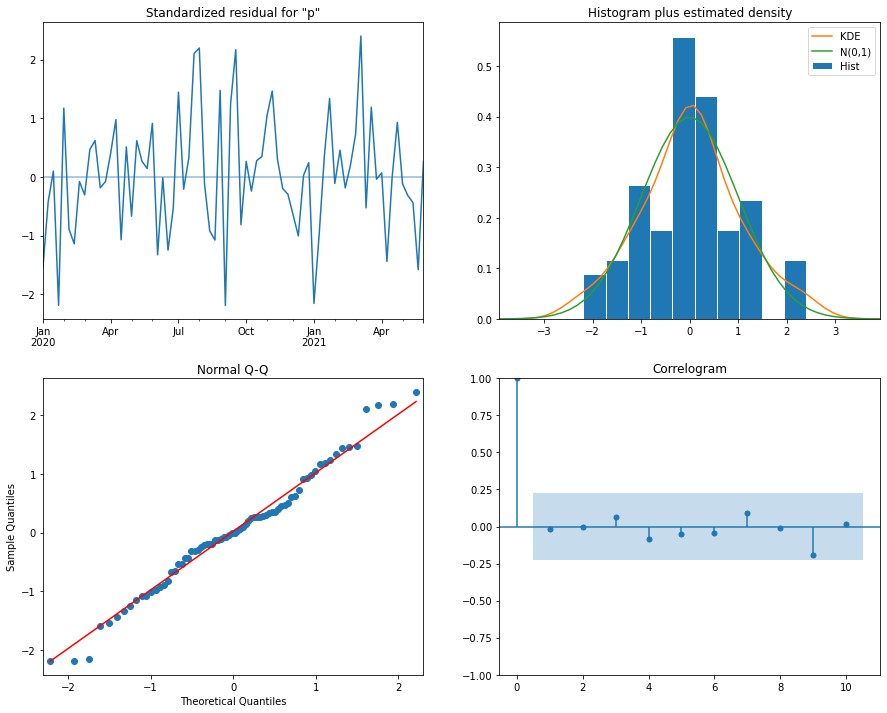


 PAPI Residuals:


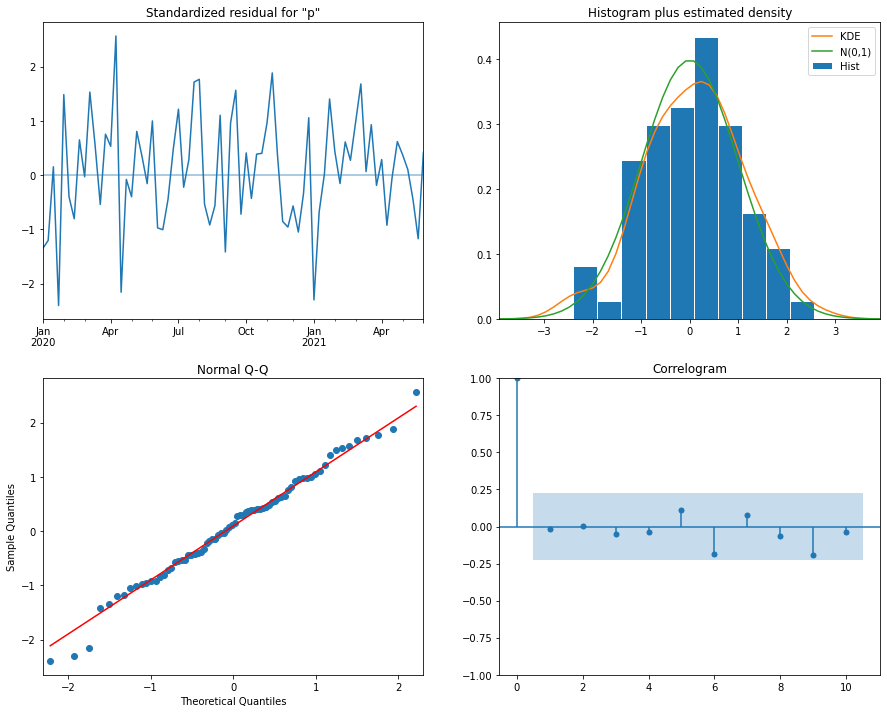


 Imperium Subcap Residuals:


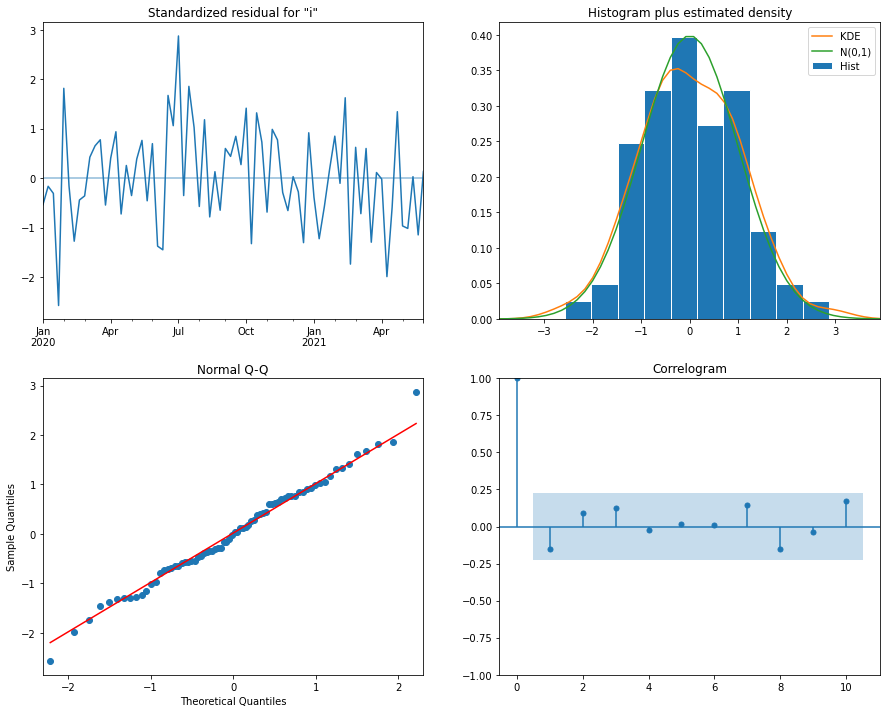


 PAPI Subcap Residuals:


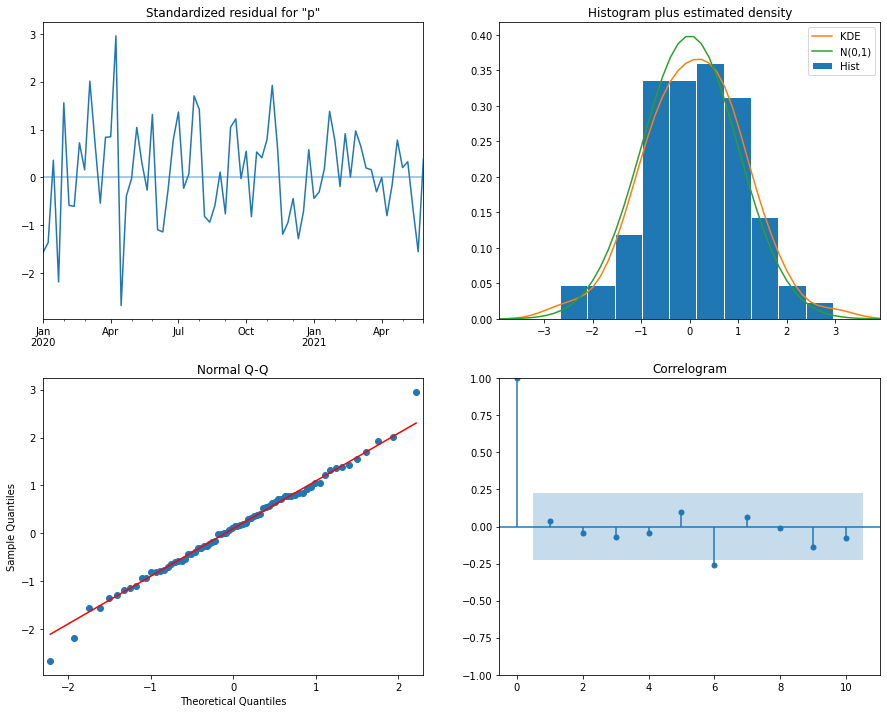

In [260]:
print("Imperium Residuals:")
imp_fit.plot_diagnostics(figsize=(15, 12))
plt.show()
print("\n", "Legacy Residuals:")
legacy_fit.plot_diagnostics(figsize=(15, 12))
plt.show()
print("\n", "Panfam Residuals:")
panfam_fit.plot_diagnostics(figsize=(15, 12))
plt.show()
print("\n", "PAPI Residuals:")
papi_fit.plot_diagnostics(figsize=(15, 12))
plt.show()
print("\n", "Imperium Subcap Residuals:")
impsub_fit.plot_diagnostics(figsize=(15, 12))
plt.show()
print("\n", "PAPI Subcap Residuals:")
papisub_fit.plot_diagnostics(figsize=(15, 12))
plt.show()

### For all cases, the model diagnostics suggest that the residuals are near normally distributed. Additionlly, the correlograms show that the autocorrelation has been properly taken into account.

In [261]:
import numpy as np

def MAPE(actual, pred):
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

MAPE: 6.879862099526825


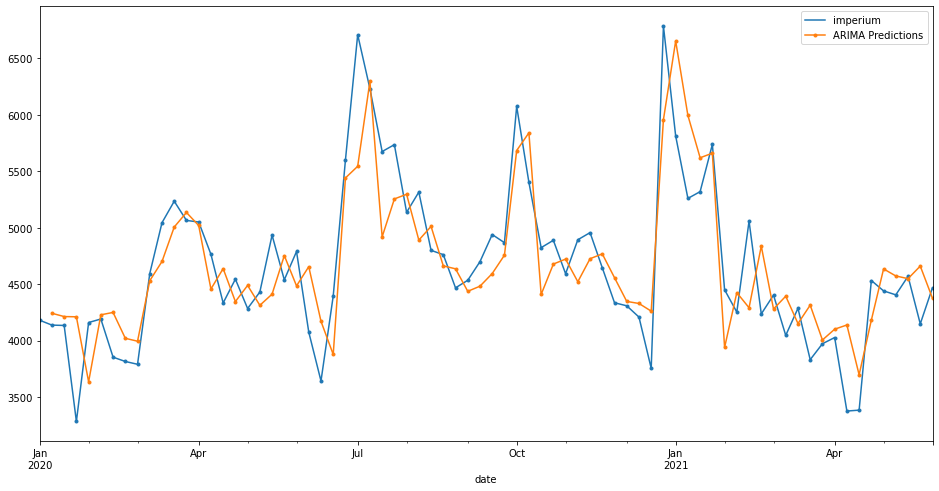

In [288]:
start=1
end=len(imp_df)-1
imp_pred=imp_fit.predict(start=start,end=end,typ='levels', exog = exogx, dynamic=False).rename('ARIMA Predictions')

plt.rcParams["figure.figsize"] = (16,8)
imp_df.plot(legend = True, marker = ".")
imp_pred.plot(legend=True, marker = ".")

actual = imp_df[1:74]
pred = imp_pred

print("MAPE:", MAPE(actual, pred))

MAPE: 5.539491017342847


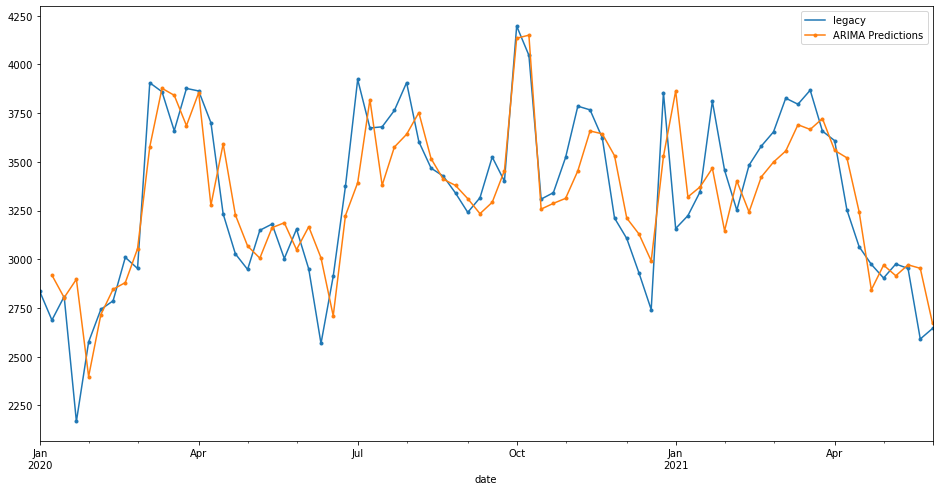

In [287]:
start=1
end=len(legacy_df)-1
legacy_pred=legacy_fit.predict(start=start,end=end,typ='levels', exog = exogx, dynamic=False).rename('ARIMA Predictions')

plt.rcParams["figure.figsize"] = (16,8)
legacy_df.plot(legend = True, marker = ".")
legacy_pred.plot(legend=True, marker = ".")

actual = legacy_df[1:74]
pred = legacy_pred

print("MAPE:", MAPE(actual, pred))

MAPE: 6.32702207978346


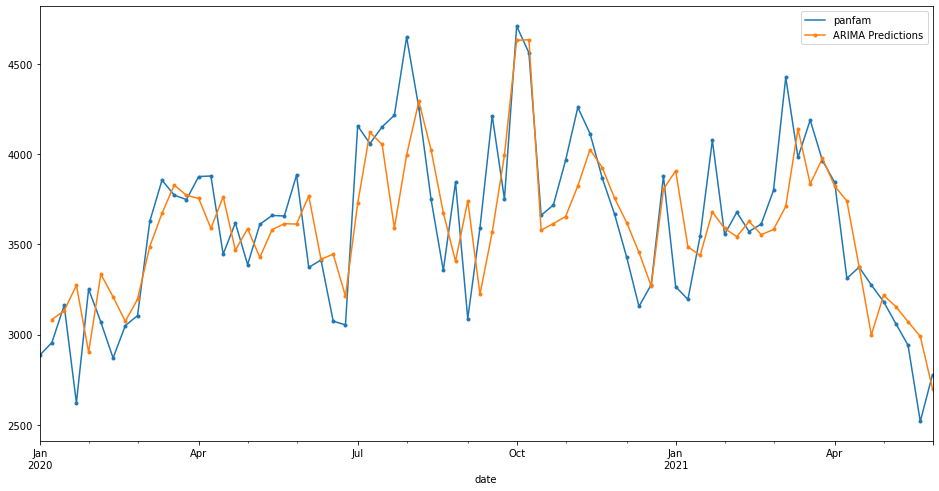

In [286]:
start =1
end=len(panfam_df)-1
panfam_pred=panfam_fit.predict(start=start,end=end,typ='levels', exog = exogx3, dynamic=False).rename('ARIMA Predictions')

plt.rcParams["figure.figsize"] = (16,8)
panfam_df.plot(legend = True, marker = ".")
panfam_pred.plot(legend=True, marker = ".")

actual = panfam_df[1:74]
pred = panfam_pred

print("MAPE:", MAPE(actual, pred))

MAPE: 5.0773101650901795


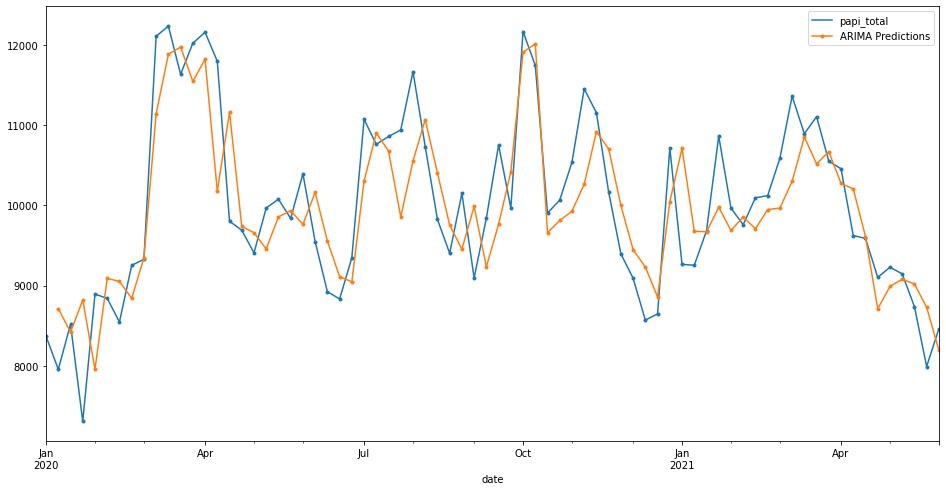

In [285]:
start =1
end=len(papi_df)-1
papi_pred=papi_fit.predict(start=start,end=end,typ='levels', exog = exogx3, dynamic=False).rename('ARIMA Predictions')

plt.rcParams["figure.figsize"] = (16,8)
papi_df.plot(legend = True, marker = ".")
papi_pred.plot(legend=True, marker = ".")

actual = papi_df[1:74]
pred = papi_pred

print("MAPE:", MAPE(actual, pred))

MAPE: 6.194745624705209


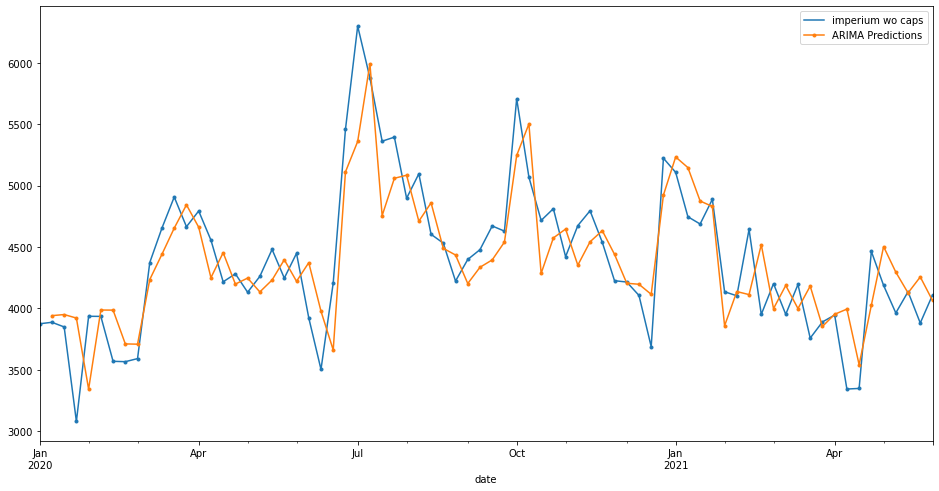

In [284]:
start =1
end=len(impsub_df)-1
impsub_pred=impsub_fit.predict(start=start,end=end,typ='levels', exog = exogx, dynamic=False).rename('ARIMA Predictions')

plt.rcParams["figure.figsize"] = (16,8)
impsub_df.plot(legend = True, marker = ".")
impsub_pred.plot(legend=True, marker = ".")

actual = impsub_df[1:74]
pred = impsub_pred

print("MAPE:", MAPE(actual, pred))

MAPE: 4.356215272588451


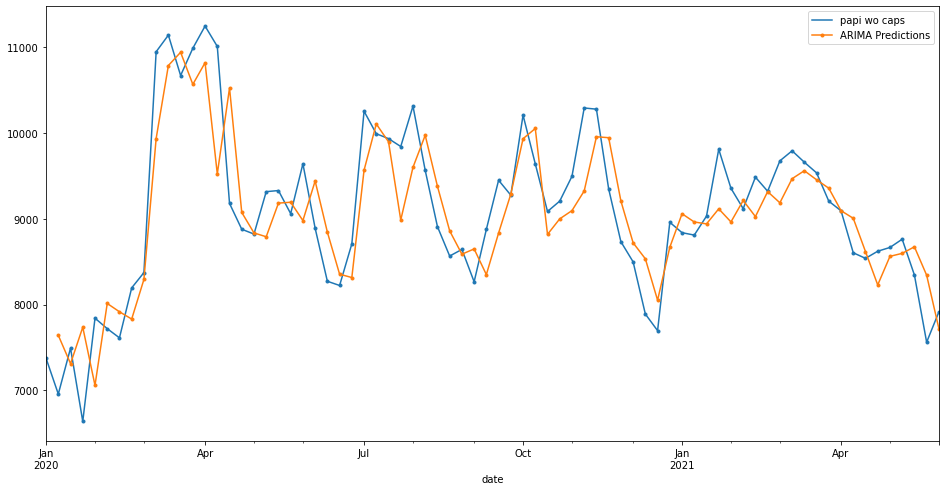

In [283]:
start =1
end=len(papisub_df)-1
papisub_pred=papisub_fit.predict(start=start,end=end,typ='levels', exog = exogx3, dynamic=False).rename('ARIMA Predictions')

plt.rcParams["figure.figsize"] = (16,8)
papisub_df.plot(legend = True, marker = ".")
papisub_pred.plot(legend=True, marker = ".")

actual = papisub_df[1:74]
pred = papisub_pred

print("MAPE:", MAPE(actual, pred))

## Plotting the Forecasts:

The further out you go in your prediction, the greater the chances for error. We will be conservative and forecast 10 weeks out from the latest available data point. An industry-standard 80% confidence interval was chosen for the prediction period.

In [269]:
exogx2 = evedata_df[['northern_conflict', "war_begins", "fwst", "m2", "1dq_siege"]].iloc[75:85]
exogx4 = evedata_df[['northern_conflict', "war_begins_panfam", "fwst", "m2", "1dq_siege"]].iloc[75:85]

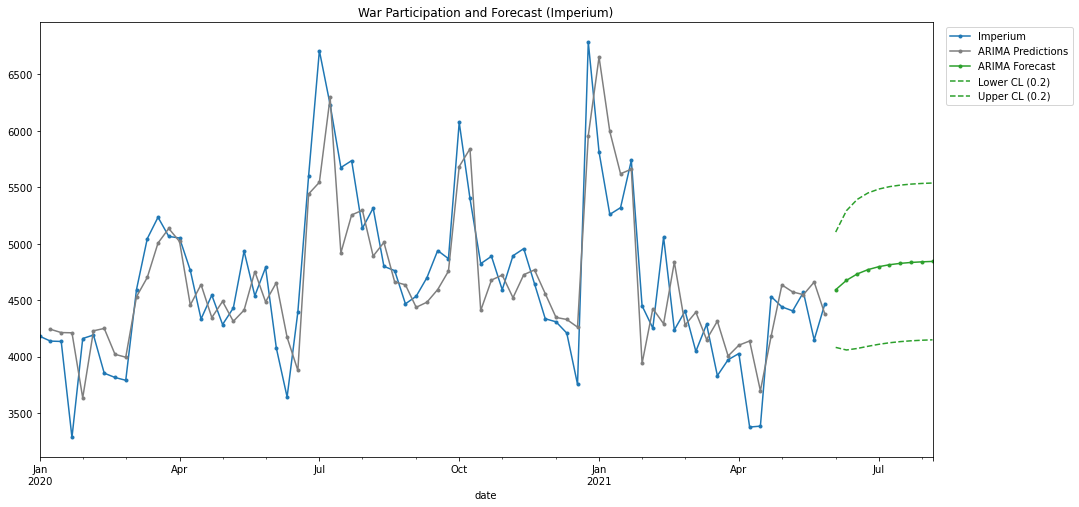

In [353]:
imp_forecast=imp_fit.forecast(steps = 10, exog = exogx2).rename('ARIMA Forecast')
imp_forecast2 = imp_fit.get_forecast(steps = 10, exog = exogx2, alpha = 0.2)
imp_yhat = imp_forecast2.predicted_mean
imp_conf_int = imp_forecast2.conf_int(alpha=0.2)

plt.rcParams["figure.figsize"] = (16,8)

plt.title("War Participation and Forecast (Imperium)")

imp_df.plot(legend = True, color = "tab:blue", marker = ".", label = "Imperium")
imp_pred.plot(legend=True, color = "tab:grey", marker = ".")
imp_forecast.plot(legend=True, color = "tab:green", marker = ".")
imp_conf_int["lower imperium"].plot(legend=True, color = "tab:green", linestyle = "dashed", label = "Lower CL (0.2)")
imp_conf_int["upper imperium"].plot(legend=True, color = "tab:green", linestyle = "dashed", label = "Upper CL (0.2)")
plt.legend(bbox_to_anchor=(1.01,1), loc="upper left")
plt.savefig('imperium_arima.png', bbox_inches='tight')

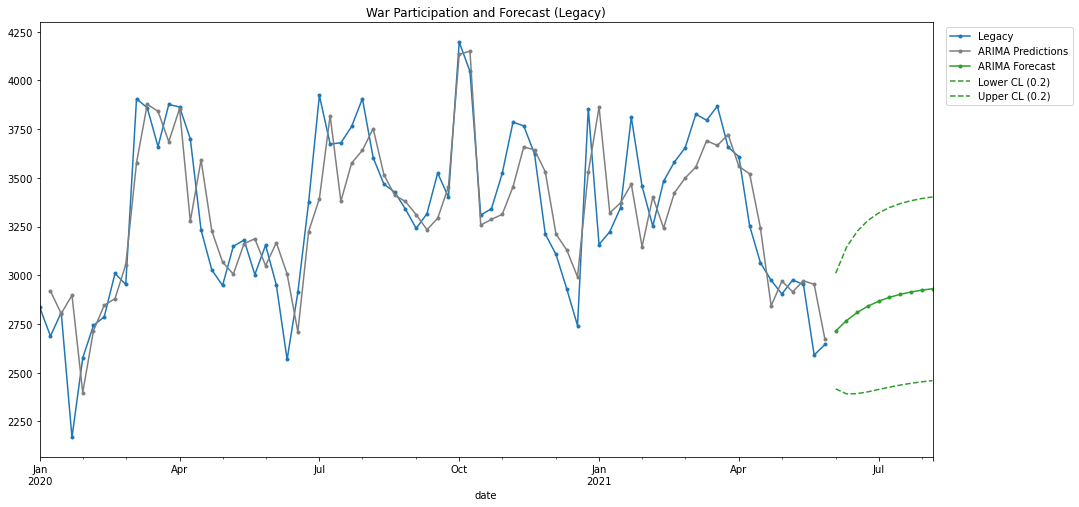

In [354]:
legacy_forecast=legacy_fit.forecast(steps = 10, exog = exogx2).rename('ARIMA Forecast')
legacy_forecast2 = legacy_fit.get_forecast(steps = 10, exog = exogx2, alpha = 0.2)
legacy_yhat = legacy_forecast2.predicted_mean
legacy_conf_int = legacy_forecast2.conf_int(alpha=0.2)

plt.rcParams["figure.figsize"] = (16,8)

plt.title("War Participation and Forecast (Legacy)")

legacy_df.plot(legend = True, color = "tab:blue", marker = ".", label = "Legacy")
legacy_pred.plot(legend=True, color = "tab:grey", marker = ".")
legacy_forecast.plot(legend=True, color = "tab:green", marker = ".")
legacy_conf_int["lower legacy"].plot(legend=True, color = "tab:green", linestyle = "dashed", label = "Lower CL (0.2)")
legacy_conf_int["upper legacy"].plot(legend=True, color = "tab:green", linestyle = "dashed", label = "Upper CL (0.2)")
plt.legend(bbox_to_anchor=(1.01,1), loc="upper left")
plt.savefig('legacy_arima.png', bbox_inches='tight')

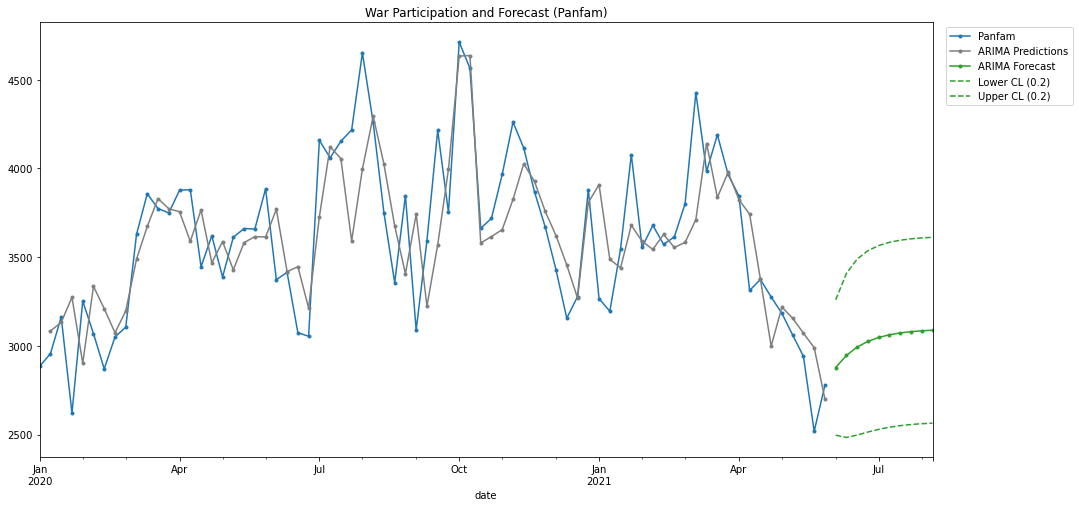

In [355]:
panfam_forecast=panfam_fit.forecast(steps = 10, exog = exogx4).rename('ARIMA Forecast')
panfam_forecast2 = panfam_fit.get_forecast(steps = 10, exog = exogx4, alpha = 0.2)
panfam_yhat = panfam_forecast2.predicted_mean
panfam_conf_int = panfam_forecast2.conf_int(alpha=0.2)

plt.rcParams["figure.figsize"] = (16,8)

plt.title("War Participation and Forecast (Panfam)")

panfam_df.plot(legend = True, color = "tab:blue", marker = ".", label = "Panfam")
panfam_pred.plot(legend=True, color = "tab:grey", marker = ".")
panfam_forecast.plot(legend=True, color = "tab:green", marker = ".")
panfam_conf_int["lower panfam"].plot(legend=True, color = "tab:green", linestyle = "dashed", label = "Lower CL (0.2)")
panfam_conf_int["upper panfam"].plot(legend=True, color = "tab:green", linestyle = "dashed", label = "Upper CL (0.2)")
plt.legend(bbox_to_anchor=(1.01,1), loc="upper left")
plt.savefig('panfam_arima.png', bbox_inches='tight')

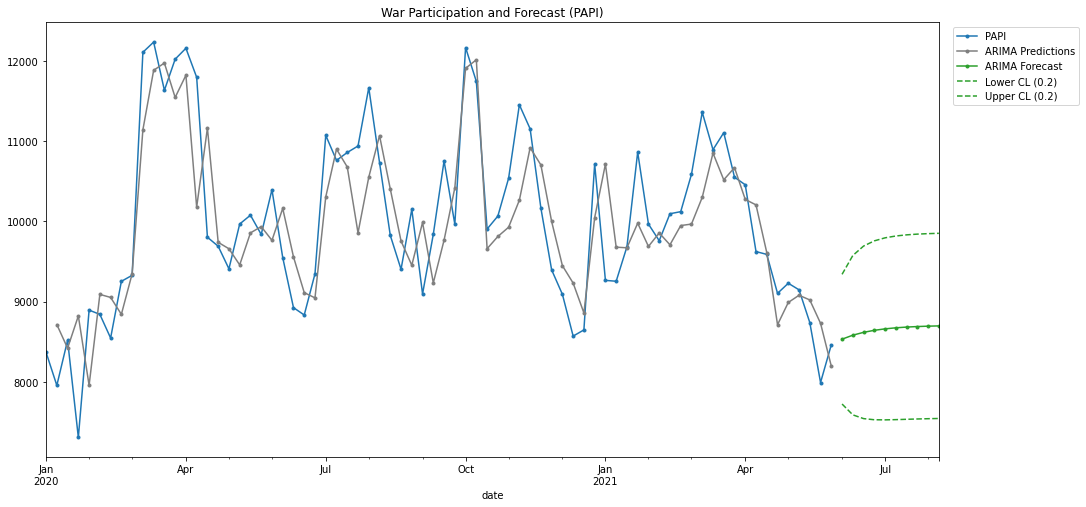

In [356]:
papi_forecast=papi_fit.forecast(steps = 10, exog = exogx4).rename('ARIMA Forecast')
papi_forecast2 = papi_fit.get_forecast(steps = 10, exog = exogx4, alpha = 0.2)
papi_yhat = papi_forecast2.predicted_mean
papi_conf_int = papi_forecast2.conf_int(alpha=0.2)

plt.rcParams["figure.figsize"] = (16,8)

plt.title("War Participation and Forecast (PAPI)")

papi_df.plot(legend = True, color = "tab:blue", marker = ".", label = "PAPI")
papi_pred.plot(legend=True, color = "tab:grey", marker = ".")
papi_forecast.plot(legend=True, color = "tab:green", marker = ".")
papi_conf_int["lower papi_total"].plot(legend=True, color = "tab:green", linestyle = "dashed", label = "Lower CL (0.2)")
papi_conf_int["upper papi_total"].plot(legend=True, color = "tab:green", linestyle = "dashed", label = "Upper CL (0.2)")
plt.legend(bbox_to_anchor=(1.01,1), loc="upper left")
plt.savefig('papi_arima.png', bbox_inches='tight')


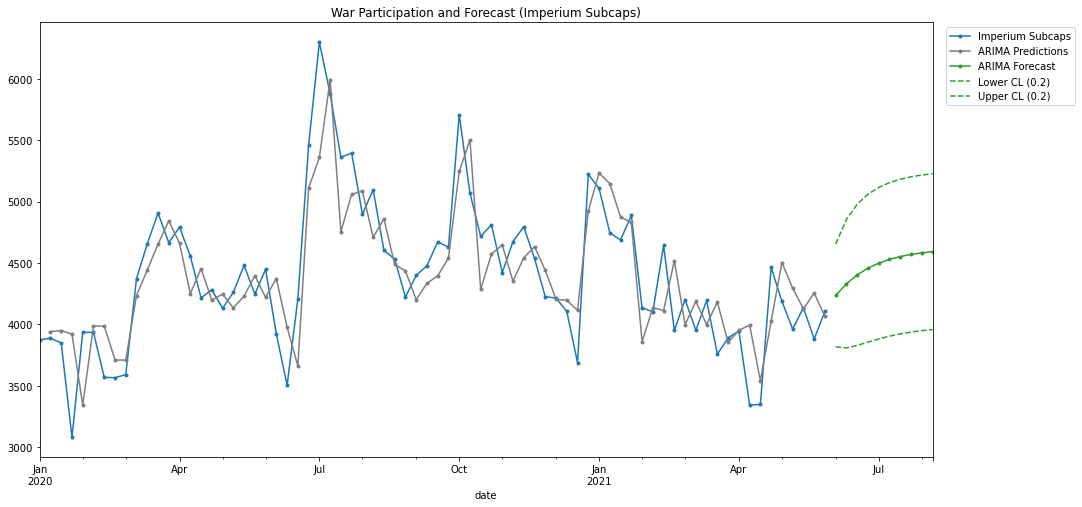

In [357]:
impsub_forecast=impsub_fit.forecast(steps = 10, exog = exogx2).rename('ARIMA Forecast')
impsub_forecast2 = impsub_fit.get_forecast(steps = 10, exog = exogx2, alpha = 0.2)
impsub_yhat = impsub_forecast2.predicted_mean
impsub_conf_int = impsub_forecast2.conf_int(alpha=0.2)

plt.rcParams["figure.figsize"] = (16,8)

plt.title("War Participation and Forecast (Imperium Subcaps)")

impsub_df.plot(legend = True, color = "tab:blue", marker = ".", label = "Imperium Subcaps")
impsub_pred.plot(legend=True, color = "tab:grey", marker = ".")
impsub_forecast.plot(legend=True, color = "tab:green", marker = ".")
impsub_conf_int["lower imperium wo caps"].plot(legend=True, color = "tab:green", linestyle = "dashed", label = "Lower CL (0.2)")
impsub_conf_int["upper imperium wo caps"].plot(legend=True, color = "tab:green", linestyle = "dashed", label = "Upper CL (0.2)")
plt.legend(bbox_to_anchor=(1.01,1), loc="upper left")
plt.savefig('impsub_arima.png', bbox_inches='tight')


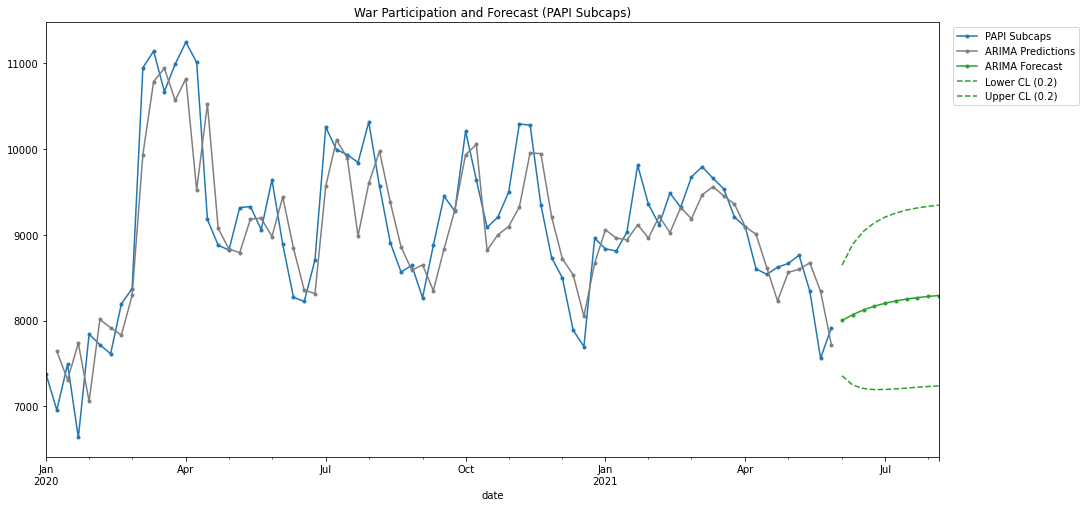

In [358]:
papisub_forecast = papisub_fit.forecast(steps = 10, exog = exogx4).rename('ARIMA Forecast')
papisub_forecast2 = papisub_fit.get_forecast(steps = 10, exog = exogx4, alpha = 0.2)
papisub_yhat = papisub_forecast2.predicted_mean
papisub_conf_int = papisub_forecast2.conf_int(alpha=0.2)

plt.rcParams["figure.figsize"] = (16,8)

plt.title("War Participation and Forecast (PAPI Subcaps)")

papisub_df.plot(legend = True, color = "tab:blue", marker = ".", label = "PAPI Subcaps")
papisub_pred.plot(legend=True, color = "tab:grey", marker = ".")
papisub_forecast.plot(legend=True, color = "tab:green", marker = ".")
papisub_conf_int["lower papi wo caps"].plot(legend=True, color = "tab:green", linestyle = "dashed", label = "Lower CL (0.2)")
papisub_conf_int["upper papi wo caps"].plot(legend=True, color = "tab:green", linestyle = "dashed", label = "Upper CL (0.2)")
plt.legend(bbox_to_anchor=(1.01,1), loc="upper left")
plt.savefig('papisub_arima.png', bbox_inches='tight')


## Combined Plot for the "Big 3" War Participants:



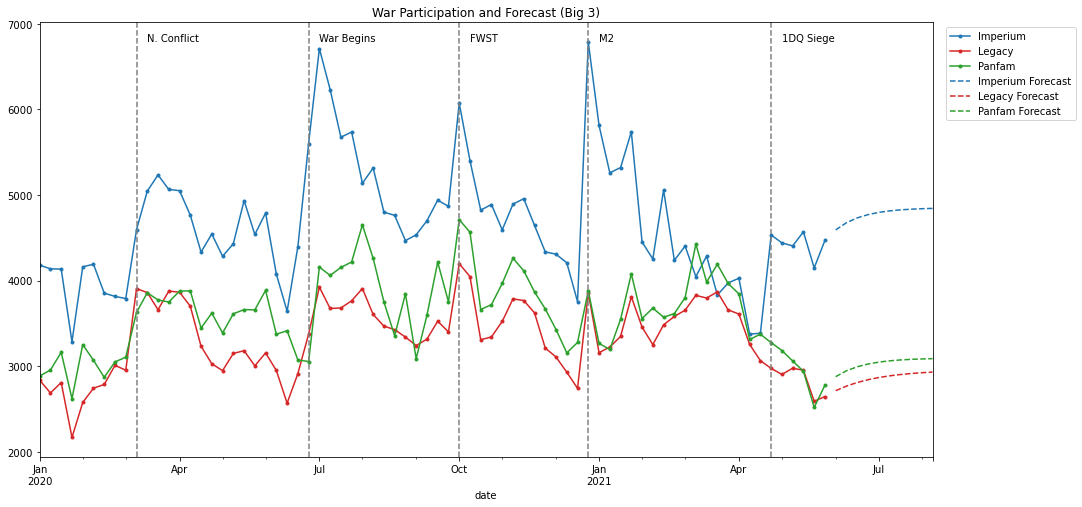

In [359]:
plt.rcParams["figure.figsize"] = (16,8)

plt.title('War Participation and Forecast (Big 3)')

imp_df.plot(legend=True, color = "tab:blue", marker = ".", label = "Imperium")
legacy_df.plot(legend=True, color = "tab:red", marker = ".", label = "Legacy")
panfam_df.plot(legend=True, color = "tab:green", marker = ".", label = "Panfam")

imp_forecast.plot(legend=True, color = "tab:blue", linestyle = "dashed", label = "Imperium Forecast")
legacy_forecast.plot(legend=True, color = "tab:red", linestyle = "dashed", label = "Legacy Forecast")
panfam_forecast.plot(legend=True, color = "tab:green", linestyle = "dashed", label = "Panfam Forecast")

#Plot intervention events
plt.axvline(x="2020-03-09", color = "grey", linestyle = "dashed")
plt.text("2020-03-16",6800,"N. Conflict")
plt.axvline(x="2020-06-29", color = "grey", linestyle = "dashed")
plt.text("2020-07-06",6800,"War Begins")
plt.axvline(x="2020-10-05", color = "grey", linestyle = "dashed")
plt.text("2020-10-12",6800,"FWST")
plt.axvline(x="2020-12-28", color = "grey", linestyle = "dashed")
plt.text("2021-01-04",6800,"M2")
plt.axvline(x="2021-04-26", color = "grey", linestyle = "dashed")
plt.text("2021-05-03",6800,"1DQ Siege")


plt.legend(bbox_to_anchor=(1.01,1), loc="upper left")
plt.savefig('combined_arima.png', bbox_inches='tight')

In [416]:
imp_pred_df = pd.DataFrame(imp_pred.values, index = imp_pred.index, columns = ["Imperium Prediction and Forecast"])
legacy_pred_df = pd.DataFrame(legacy_pred.values, index = legacy_pred.index, columns = ["Legacy Prediction and Forecast"])
panfam_pred_df = pd.DataFrame(panfam_pred.values, index = panfam_pred.index, columns = ["Panfam Prediction and Forecast"])
papi_pred_df = pd.DataFrame(papi_pred.values, index = papi_pred.index, columns = ["PAPI Prediction and Forecast"])
impsub_pred_df = pd.DataFrame(impsub_pred.values, index = impsub_pred.index, columns = ["Imperium Subcap Prediction and Forecast"])
papisub_pred_df = pd.DataFrame(papisub_pred.values, index = papisub_pred.index, columns = ["PAPI Subcap Prediction and Forecast"])

In [420]:
imp_fc_df = pd.DataFrame(imp_forecast.values, index = imp_forecast.index, columns = ["Imperium Prediction and Forecast"])
legacy_fc_df = pd.DataFrame(legacy_forecast.values, index = legacy_forecast.index, columns = ["Legacy Prediction and Forecast"])
panfam_fc_df = pd.DataFrame(panfam_forecast.values, index = panfam_forecast.index, columns = ["Panfam Prediction and Forecast"])
papi_fc_df = pd.DataFrame(papi_forecast.values, index = papi_forecast.index, columns = ["PAPI Prediction and Forecast"])
impsub_fc_df = pd.DataFrame(impsub_forecast.values, index = impsub_forecast.index, columns = ["Imperium Subcap Prediction and Forecast"])
papisub_fc_df = pd.DataFrame(papisub_forecast.values, index = papisub_forecast.index, columns = ["PAPI Subcap Prediction and Forecast"])

In [432]:
temp_df1 = pd.concat([imp_pred_df, legacy_pred_df, panfam_pred_df, papi_pred_df, impsub_pred_df, papisub_pred_df] , axis=1)
temp_df2 = pd.concat([imp_fc_df, legacy_fc_df, panfam_fc_df, papi_fc_df, impsub_fc_df, papisub_fc_df] , axis=1)
temp_df3 = pd.concat([temp_df1, temp_df2], axis = 0)
print(temp_df3)

            Imperium Prediction and Forecast  Legacy Prediction and Forecast  \
2020-01-13                       4241.782424                     2918.733670   
2020-01-20                       4212.639150                     2803.446102   
2020-01-27                       4210.605899                     2897.701478   
2020-02-03                       3634.517940                     2398.381673   
2020-02-10                       4228.227413                     2716.201456   
...                                      ...                             ...   
2021-07-12                       4813.485716                     2887.020633   
2021-07-19                       4825.399701                     2902.410775   
2021-07-26                       4833.474411                     2914.399234   
2021-08-02                       4838.947050                     2923.737885   
2021-08-09                       4842.656134                     2931.012414   

            Panfam Prediction and Forec

In [ ]:
papisub_conf_int

In [449]:
forecast_values = pd.concat([temp_df3, imp_conf_int, legacy_conf_int, panfam_conf_int, papi_conf_int, impsub_conf_int, papisub_conf_int, ], axis = 1)

forecast_values = forecast_values[['Imperium Prediction and Forecast', 'lower imperium', 'upper imperium', 'Legacy Prediction and Forecast', 'lower legacy', 'upper legacy', 
'Panfam Prediction and Forecast', 'lower panfam', 'upper panfam', 'PAPI Prediction and Forecast', 'lower papi_total', 'upper papi_total', 
'Imperium Subcap Prediction and Forecast', 'lower imperium wo caps', 'upper imperium wo caps', 'PAPI Subcap Prediction and Forecast',  'lower papi wo caps',
 'upper papi wo caps' ]]

forecast_values.to_csv(os.path.join('export_data','eve_forecastvalues.csv'))

## Conclusion

Something that surprised me to discover was just how differently each group reacted to the 1DQ siege. The start of this event had a significant positive impact on the Imperium, while it had an almost meaningless negative impact on PAPI. This is because PAPI was already in steep decline before the start of the siege. On the other hand, the continuing effects of the siege have impacted PAPI much more than the Imperium- with a significant, ongoing negative effect for PAPI and a slight positive effect on the Imperium. While the participation numbers will tend to revert toward their individual means, the ongoing negative effects of the 1DQ siege are impacting Panfam much more than Legacy. 

**It's plain to see that our models predict good news for the Imperium, and a dire warning for PAPI.** If their strategy doesn't change, the Imperium's numbers will continue to rise, while PAPI's numbers will stagnate. It's important to take note of the confidence bands around these predictions- in the case of the Imperium, the tighter band predicts, at worst, slightly lower numbers, while PAPI has a larger capacity to underperform.

*Note: Roughly 4 months after original publication of this work, PAPI would go on to lose the war through a lack of participation - see [this article](https://massivelyop.com/2021/08/03/eve-onlines-record-breaking-world-war-bee-2-has-seemingly-come-to-an-end/ "PC Games Article on the end of WWB 2") for more information.*

